# Exploratory Data Analysis (EDA) - Benin Dataset
This notebook performs EDA: summary statistics, missing-value analysis, outlier detection, and basic cleaning.

In [35]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy import stats
import os


In [29]:
# Load Benin dataset
df = pd.read_csv('../src/data/benin-malanville.csv')
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [30]:
# Summary statistics for numeric columns
print(df.dtypes)

Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object


### Summary Statistics & Missing-Value Report


In [31]:
summary_stats = df.describe()
print("Summary statistics:\n", summary_stats)


Summary statistics:
                  GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         

In [32]:

# 2. Count of missing values per column
missing_counts = df.isna().sum()
print("\nMissing‐value counts:\n", missing_counts)



Missing‐value counts:
 Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


In [33]:
# 3. Percentage of missing values per column
missing_percent = (missing_counts / len(df)) * 100
print("\nMissing‐value percentages:\n", missing_percent.round(2))



Missing‐value percentages:
 Timestamp          0.0
GHI                0.0
DNI                0.0
DHI                0.0
ModA               0.0
ModB               0.0
Tamb               0.0
RH                 0.0
WS                 0.0
WSgust             0.0
WSstdev            0.0
WD                 0.0
WDstdev            0.0
BP                 0.0
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
Comments         100.0
dtype: float64


In [34]:
cols_over_5pct = missing_percent[missing_percent > 5].index.tolist()
print("\nColumns with more than 5% missing: ", cols_over_5pct)



Columns with more than 5% missing:  ['Comments']


### Outlier Detection & Basic Cleaning


In [43]:
COUNTRY         = "benin"             # used for naming the output file
OUTLIER_THRESH  = 3.0                    # Z-score threshold
DROP_OUTLIERS   = False                  # set True to remove flagged rows


In [40]:
# 3. Columns to analyze
sensor_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]

# 4. Compute medians for imputation and fillna for Z-score calc
medians = df[sensor_cols].median()
filled_for_z = df[sensor_cols].fillna(medians)



In [41]:

# 5. Compute Z-scores and flag outliers
z_scores = stats.zscore(filled_for_z)
abs_z    = pd.DataFrame(abs(z_scores), columns=sensor_cols, index=df.index)
df["is_outlier"] = abs_z.gt(OUTLIER_THRESH).any(axis=1)

print(f"Flagged {df['is_outlier'].sum()} outliers out of {len(df)} total rows.")


Flagged 7740 outliers out of 525600 total rows.


In [42]:
# 6. Impute missing values (median) without chained assignment
for col in sensor_cols:
    df[col] = df[col].fillna(medians[col])



In [44]:

# 8. Export cleaned data
os.makedirs("data", exist_ok=True)
out_path = f"data/{COUNTRY}_clean.csv"
df.to_csv(out_path, index=False)
print(f"Cleaned data written to: {out_path}")


Cleaned data written to: data/benin_clean.csv


### Time series Analysis

In [46]:
import matplotlib.pyplot as plt


In [47]:
CLEAN_PATH = "data/benin_clean.csv" 


In [48]:
df = pd.read_csv(CLEAN_PATH, parse_dates=["Timestamp"])
df = df.sort_values("Timestamp")



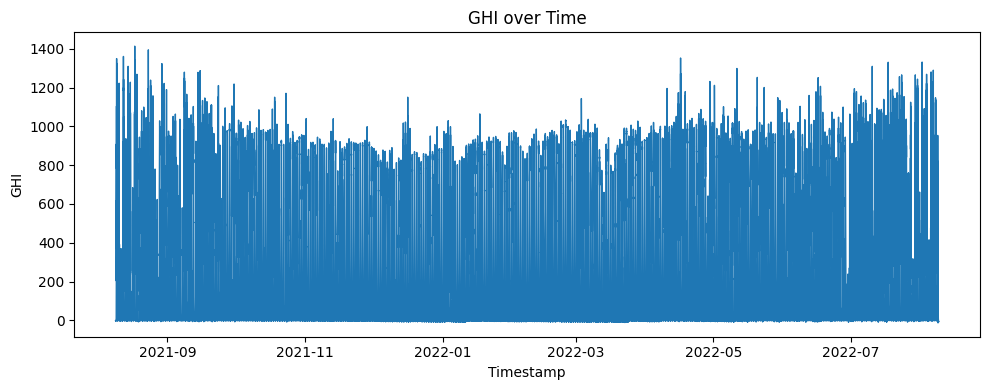

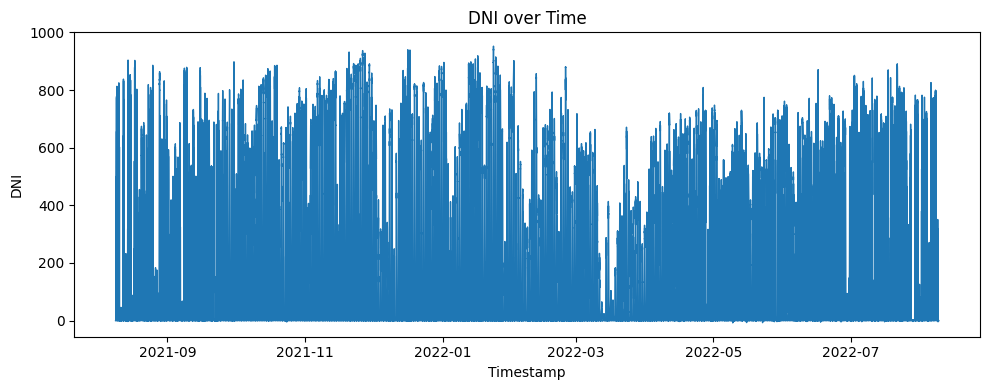

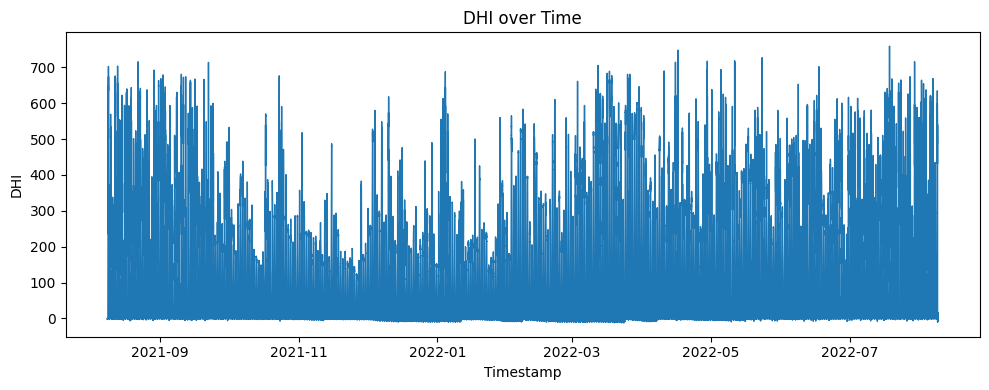

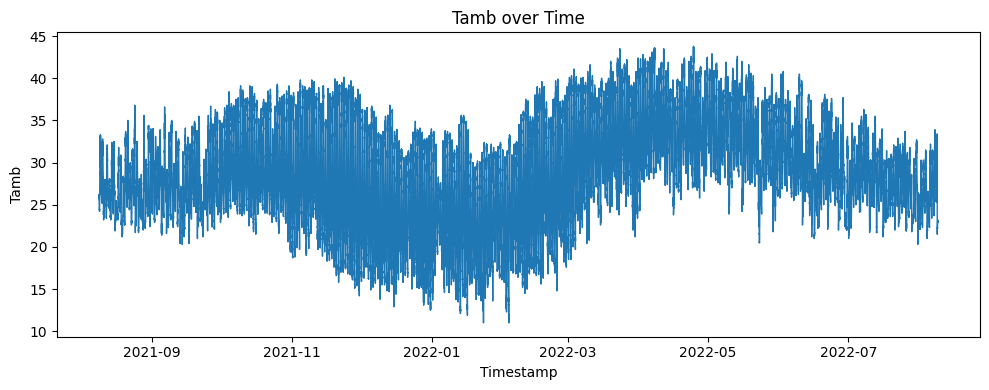

In [49]:
# Time-series line plots
for var in ["GHI", "DNI", "DHI", "Tamb"]:
    plt.figure(figsize=(10, 4))
    plt.plot(df["Timestamp"], df[var], linewidth=1)
    plt.title(f"{var} over Time")
    plt.xlabel("Timestamp")
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()



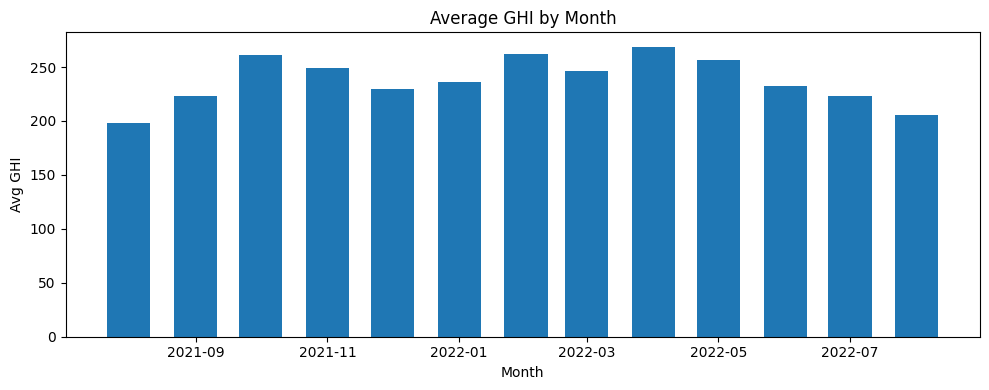

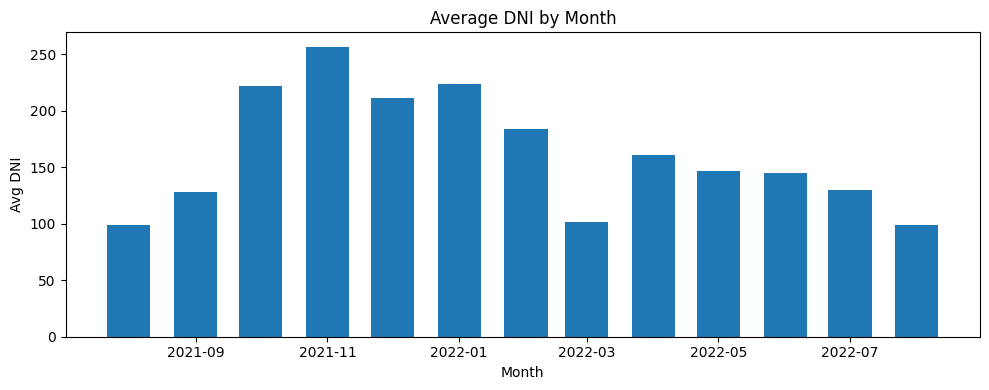

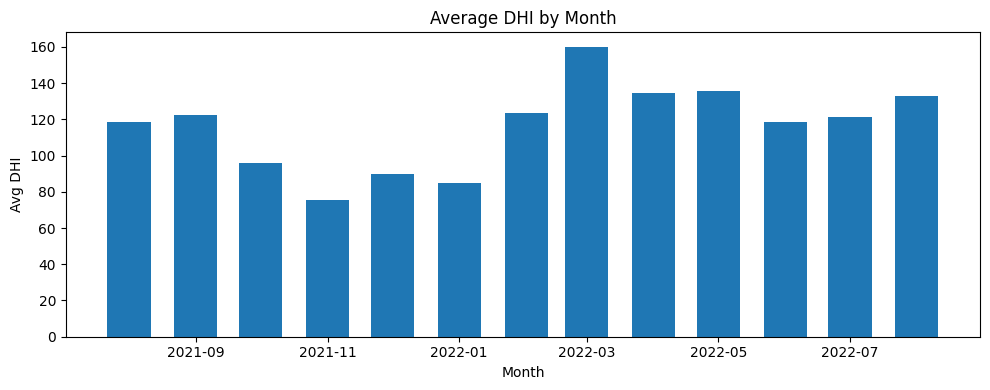

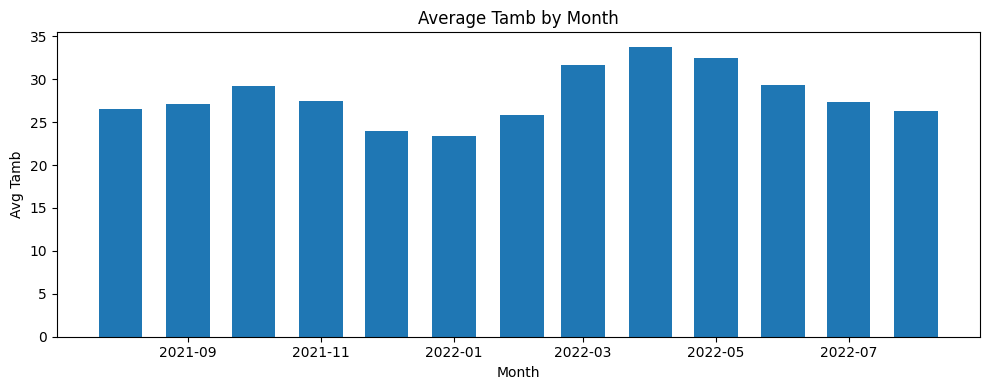

In [50]:
# Monthly averages bar charts
df["Month"] = df["Timestamp"].dt.to_period("M")
monthly_avg = df.groupby("Month")[["GHI", "DNI", "DHI", "Tamb"]].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()

for var in ["GHI", "DNI", "DHI", "Tamb"]:
    plt.figure(figsize=(10, 4))
    plt.bar(monthly_avg["Month"], monthly_avg[var], width=20)  # width in days
    plt.title(f"Average {var} by Month")
    plt.xlabel("Month")
    plt.ylabel(f"Avg {var}")
    plt.tight_layout()
    plt.show()


### Cleaning Impact


In [ ]:
# Ensure 'Cleaning' is boolean

df["Cleaning"] = df["Cleaning"].astype(bool)


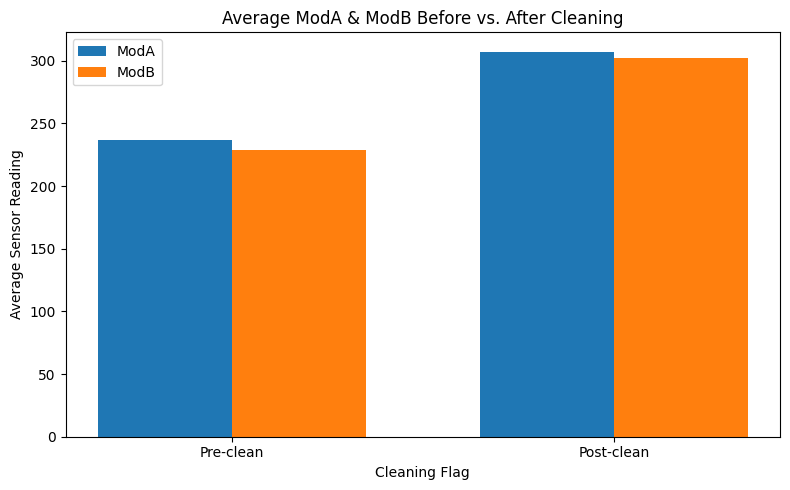

In [54]:

# Compute average ModA & ModB pre‐ and post‐clean
grouped = (
    df
    .groupby("Cleaning")[["ModA", "ModB"]]
    .mean()
    .reset_index()
)

# Plot side‐by‐side bar chart
labels = grouped["Cleaning"].map({False: "Pre‐clean", True: "Post‐clean"})
x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, grouped["ModA"], width=width, label="ModA")
plt.bar([i + width for i in x], grouped["ModB"], width=width, label="ModB")
plt.xticks([i + width/2 for i in x], labels)
plt.xlabel("Cleaning Flag")
plt.ylabel("Average Sensor Reading")
plt.title("Average ModA & ModB Before vs. After Cleaning")
plt.legend()
plt.tight_layout()


### Correlation & Relationship Analysis


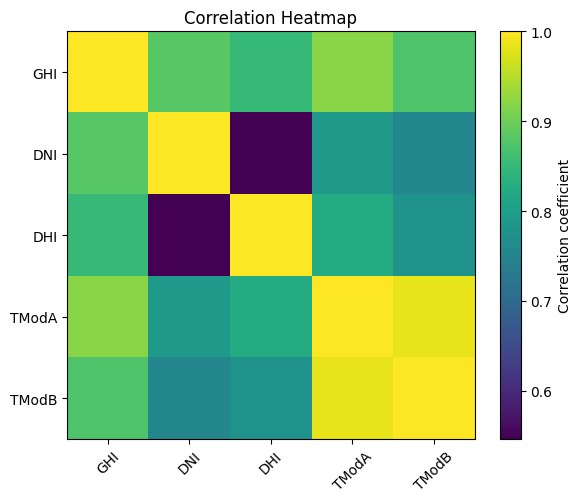

In [55]:

# Compute correlation matrix for GHI, DNI, DHI, TModA, TModB
corr_cols = ["GHI", "DNI", "DHI", "TModA", "TModB"]
corr_matrix = df[corr_cols].corr()

# Plot heatmap of correlations
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix, aspect='equal', interpolation='nearest')
plt.colorbar(label="Correlation coefficient")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


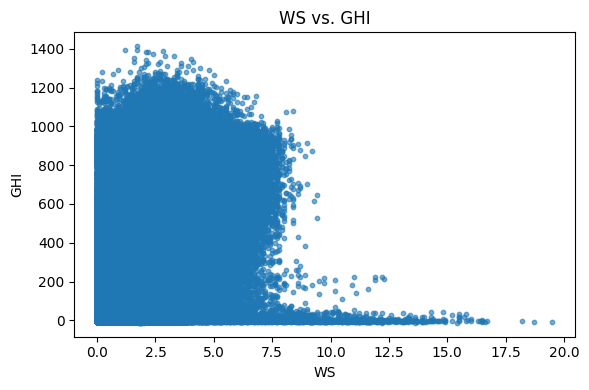

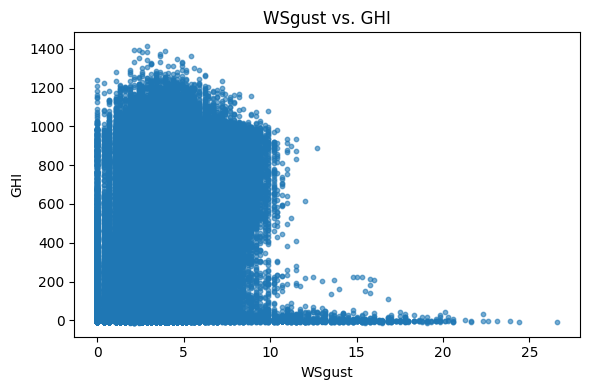

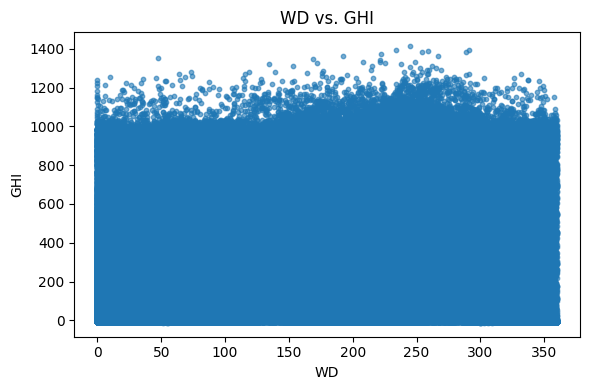

In [56]:
# Scatter plots of WS, WSgust, WD vs. GHI
for var in ["WS", "WSgust", "WD"]:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[var], df["GHI"], s=10, alpha=0.6)
    plt.xlabel(var)
    plt.ylabel("GHI")
    plt.title(f"{var} vs. GHI")
    plt.tight_layout()
    plt.show()


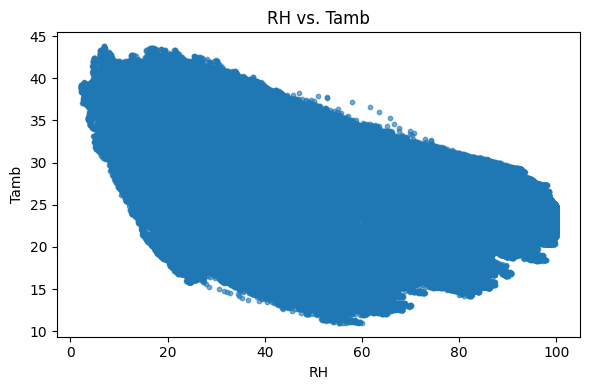

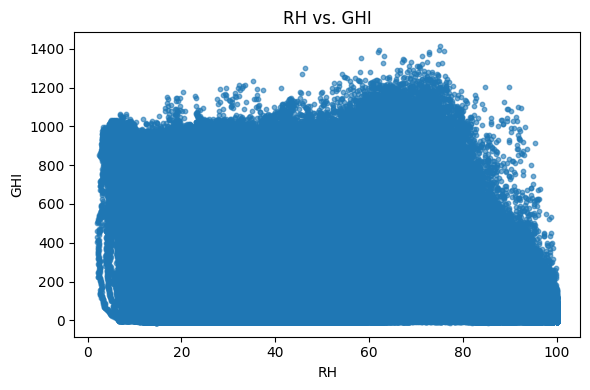

In [57]:
# 5. Scatter plots: RH vs. Tamb and RH vs. GHI
plt.figure(figsize=(6, 4))
plt.scatter(df["RH"], df["Tamb"], s=10, alpha=0.6)
plt.xlabel("RH")
plt.ylabel("Tamb")
plt.title("RH vs. Tamb")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(df["RH"], df["GHI"], s=10, alpha=0.6)
plt.xlabel("RH")
plt.ylabel("GHI")
plt.title("RH vs. GHI")
plt.tight_layout()
plt.show()
